In [103]:
import pandas as pd
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc



pd.set_option('display.max_colwidth', 1)

[nltk_data] Downloading package stopwords to /home/amanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Separando e Vetorizando os dados

In [5]:
train = pd.read_csv('train_irony.csv')
test = pd.read_csv('test_irony.csv')

In [11]:
def preprocess_data(data):
    data = data.translate(str.maketrans('', '', string.punctuation))
    data = data.lower()
    words = data.split()
    stop_words = set(stopwords.words('portuguese'))
    words = [word for word in words if word not in stop_words]
    data = ' '.join(words)
  
    return data

In [12]:
train['text_preprocess'] = thread_map(preprocess_data, train['text'])

  0%|          | 0/15619 [00:00<?, ?it/s]

In [13]:
train.head(2)

,text,prediction,text_preprocess
0,"GRANJA COMARY – Com a notícia de que Eduardo Cunha renunciou à presidência da Câmara – cargo do qual já estava afastado – Dunga convocou uma coletiva de imprensa para dizer que renuncia ao comando da seleção brasileira. Embora tenha sido demitido do posto um mês atrás, o treinador gaúcho fez uma manobra política de forma a parecer que deixa a vaga por vontade própria. “É público e notório que a seleção está acéfala, vítima de uma interinidade bizarra”, declarou Dunga, sendo aplaudido pela bancada sub-19 do PMDB. “Somente a minha renúncia poderá por fim a essa interinidade sem prazo. A seleção não suportará esperar indefinidamente.” Ele não foi o único a aderir ao programa-de-demissão-voluntária-de-quem-já estava-tecnicamente-demitido. Em Brasília, o ex-ministro Romero Jucá convocou uma coletiva de imprensa para renunciar ao comando da pasta do Planejamento. No Rio de Janeiro, Eike Batista renunciou ao posto de pessoa mais rica do Brasil. Já em Minas Gerais, o goleiro Bruno anunciou que está deixando a camisa número 1 do Flamengo. Na contracorrente, Pedro Paulo disse ontem que não renunciará ao argumento de que todo mundo às vezes exagera numa discussão.",1,granja comary – notícia eduardo cunha renunciou presidência câmara – cargo afastado – dunga convocou coletiva imprensa dizer renuncia comando seleção brasileira embora sido demitido posto mês atrás treinador gaúcho fez manobra política forma parecer deixa vaga vontade própria “é público notório seleção acéfala vítima interinidade bizarra” declarou dunga sendo aplaudido bancada sub19 pmdb “somente renúncia poderá fim interinidade prazo seleção suportará esperar indefinidamente” único aderir programadedemissãovoluntáriadequemjá estavatecnicamentedemitido brasília exministro romero jucá convocou coletiva imprensa renunciar comando pasta planejamento rio janeiro eike batista renunciou posto pessoa rica brasil minas gerais goleiro bruno anunciou deixando camisa número 1 flamengo contracorrente pedro paulo disse ontem renunciará argumento todo mundo vezes exagera discussão
1,"Foi sancionada com vetos a Lei Complementar 173, publicada dia 28 de maio de 2020 no Diário Oficial da União, que estabelece o Programa Federativo de Enfrentamento ao Coronavírus para Estados, Distrito Federal e Municípios. O plano prevê a negociação de empréstimos, a suspensão dos pagamentos de dívidas contratadas com a União (estimadas em R$ 65 bilhões) e a entrega de R$ 60 bilhões para os governos locais aplicarem em ações de enfrentamento à pandemia.",0,sancionada vetos lei complementar 173 publicada dia 28 maio 2020 diário oficial união estabelece programa federativo enfrentamento coronavírus estados distrito federal municípios plano prevê negociação empréstimos suspensão pagamentos dívidas contratadas união estimadas r 65 bilhões entrega r 60 bilhões governos locais aplicarem ações enfrentamento pandemia


In [14]:
test['text_preprocess'] = thread_map(preprocess_data, test['text'])

  0%|          | 0/2756 [00:00<?, ?it/s]

In [16]:
test.head(2)

,text,prediction,text_preprocess
0,"Um projeto aprovado pelo Congresso Nacional pode anular dívidas tributárias de igrejas acumuladas após fiscalizações e multas aplicadas pela Receita Federal. Segundo apurou o Estadão/Broadcast, o valor do “perdão” seria de quase R$ 1 bilhão. O texto aguarda a sanção ou veto do presidente Jair Bolsonaro, que tem na bancada evangélica um importante pilar de sustentação política de seu governo. Ele tem até 11 de setembro para decidir se mantém ou não a benesse aos templos religiosos.",0,projeto aprovado congresso nacional pode anular dívidas tributárias igrejas acumuladas após fiscalizações multas aplicadas receita federal segundo apurou estadãobroadcast valor “perdão” quase r 1 bilhão texto aguarda sanção veto presidente jair bolsonaro bancada evangélica importante pilar sustentação política governo 11 setembro decidir mantém benesse templos religiosos
1,Periculum in mora – o perigo da demora – é uma expressão usada quando a lentidão da justiça pode gerar dano aos envolvidos num processo. Qualquer advogado recém-formado sabe disto. Eu a uso aqui porque a demora em se fazer cumprir a pena é o que move a PEC da 2a Instância. O cidadão comum não sabe latim e nem precisa ser Rui Barbosa para dizer que justiça atrasada não é justiça.,0,periculum in mora – perigo demora – expressão usada lentidão justiça pode gerar dano envolvidos processo qualquer advogado recémformado sabe disto uso aqui porque demora fazer cumprir pena move pec 2a instância cidadão comum sabe latim precisa rui barbosa dizer justiça atrasada justiça


In [22]:
train.shape

(15619, 3)

In [23]:
test.shape

(2756, 3)

In [24]:
train.prediction.value_counts()

0    9456
1    6163
Name: prediction, dtype: int64

In [25]:
test.prediction.value_counts()

0    1720
1    1036
Name: prediction, dtype: int64

In [17]:
X_train = train['text_preprocess']
X_test = test['text_preprocess']
y_train = train['prediction']
y_test = test['prediction']

In [18]:
# transformar os dados de texto em um vetor de recursos usando o TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### SVM

In [89]:
# criar e treinar o SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [91]:
# fazer previsões no conjunto de teste
y_pred = svm.predict(X_test)

In [92]:
# imprimir o relatório de classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1720
           1       0.98      0.97      0.97      1036

    accuracy                           0.98      2756
   macro avg       0.98      0.98      0.98      2756
weighted avg       0.98      0.98      0.98      2756



In [94]:
acc = accuracy_score(y_test, y_pred)
acc

0.9796806966618288

In [46]:
f1 = f1_score(y_test, y_pred)
f1

0.9692832764505119

In [47]:
precision = precision_score(y_test, y_pred)
precision

0.9793103448275862

In [48]:
bacc = balanced_accuracy_score(y_test, y_pred)
bacc

0.973625078566939

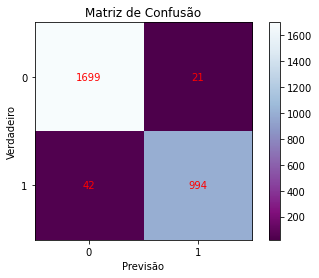

In [86]:
confusion_mat = confusion_matrix(y_test, y_pred)

plt.imshow(confusion_mat, cmap=plt.cm.BuPu_r)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.grid(False)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', color='red')
plt.show()


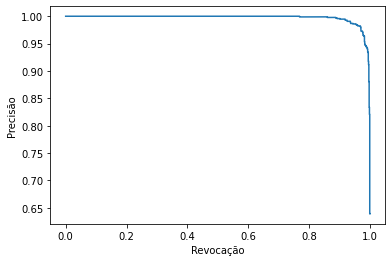

In [ ]:
y_pred_proba = svm.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

plt.plot(recall, precision)
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.show()


In [101]:
auc = auc(recall, precision)
print('AUC da curva de precisão-revocação: {:.2f}'.format(auc))


AUC da curva de precisão-revocação: 1.00


### MLP

In [105]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(70), random_state=1, verbose=True, max_iter=50)
clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=70, max_iter=50, random_state=1,
              solver='lbfgs', verbose=True)

In [106]:
# fazer previsões no conjunto de teste
y_pred_mlp = clf.predict(X_test)

In [107]:
# imprimir o relatório de classificação
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1720
           1       0.97      0.97      0.97      1036

    accuracy                           0.98      2756
   macro avg       0.97      0.98      0.98      2756
weighted avg       0.98      0.98      0.98      2756



In [108]:
acc = accuracy_score(y_test, y_pred_mlp)
acc

0.97677793904209

In [109]:
f1 = f1_score(y_test, y_pred_mlp)
f1

0.9692307692307693

In [110]:
precision = precision_score(y_test, y_pred_mlp)
precision

0.9655172413793104

In [111]:
bacc = balanced_accuracy_score(y_test, y_pred_mlp)
bacc

0.9760213702074167

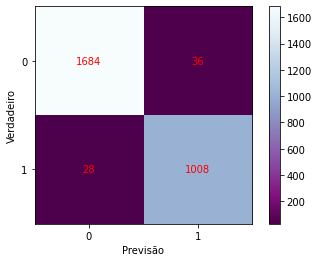

In [115]:
confusion_mat = confusion_matrix(y_test, y_pred_mlp)

plt.imshow(confusion_mat, cmap=plt.cm.BuPu_r)
plt.colorbar()
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.grid(False)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', color='red')
plt.show()


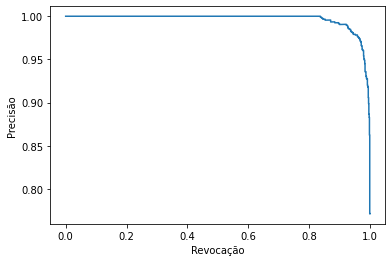

In [113]:
y_pred_proba_mlp = clf.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_mlp[:, 1])

plt.plot(recall, precision)
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.show()


In [114]:
auc = auc(recall, precision)
print('AUC da curva de precisão-revocação: {:.2f}'.format(auc))


AUC da curva de precisão-revocação: 1.00
